In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import numpy as np
from torch.nn import functional as F
import torch.nn as nn

from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import random

In [3]:
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()
data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [4]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


In [5]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
      
    return npy,torch.Tensor([self.all_labels[idx]])

In [6]:

transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_test)

transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])

train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class LiverResnet(nn.Module):
    def __init__(self,in_channels=4):
        super(LiverResnet,self).__init__()
        
        #torchvision.models에서 사전훈련된 resnet모델 가져오기
        self.model=models.resnet50(pretrained=True)
        
        #기본채널이 3이기 때문에 liver data set에 맞게 1로 바꿔줌
        #원래 resnet의 첫번째 layer
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1=nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        
        #class수 변경
        num_ftrs=self.model.fc.in_features
        self.model.fc=nn.Linear(num_ftrs,2)

    def forward(self,x):
            return self.model(x)
        
        

In [9]:
model=LiverResnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/min_resnet50.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [10]:
print(model)

LiverResnet(
  (model): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [11]:
class Extractor():
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.down_result = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def get_gradients(self):
        return self.gradients

    def __call__(self, x):
        self.gradients = []

        x.requires_grad_(True)

        
        for name,module1 in self.model.model.named_children():
            if name=='fc':
                x=module1(x.squeeze(-1).squeeze(-1))
            else:
                x=module1(x)
            if name=='layer3':  
                x.register_hook(self.save_gradient)
                target_feature_maps = x
                


        return target_feature_maps, x

class GradCam:
    def __init__(self, model, use_cuda):
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        else:
            self.model = model
        
        self.model.eval()
        self.extractor = Extractor(self.model)

    def __call__(self, input, class_num=1):
        if self.cuda:
            targets, output = self.extractor(input.cuda())
        else:
            targets, output = self.extractor(input)

        label = torch.zeros_like(output, dtype=torch.long)
        label[:, class_num] += 1

        if self.cuda:
            one_hot = torch.sum(label.cuda() * output)
        else:
            one_hot = torch.sum(label * output)
            
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        targets = targets.cpu().data.numpy()[0, :]
        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        
        grad_cam = np.zeros(targets.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            grad_cam += w * targets[i, :, :]

        grad_cam = cv2.resize(grad_cam, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        grad_cam = np.maximum(grad_cam, 0)
        cam_max, cam_min = np.max(grad_cam), np.min(grad_cam)
        if cam_max - cam_min > 0:
            grad_cam = (grad_cam - cam_min) / (cam_max - cam_min)
        else:
            grad_cam[:] = 0

        return (grad_cam * 255).astype('uint8')

In [12]:
CAM=GradCam(model,True)

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


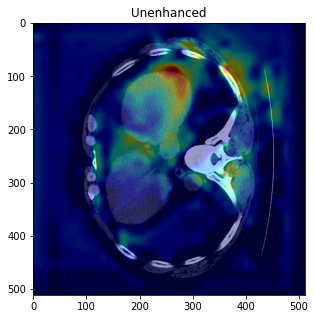

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


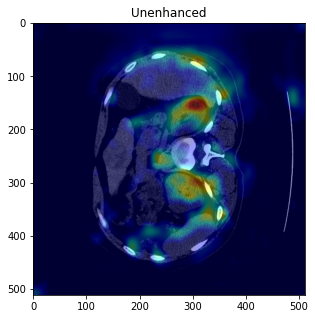

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


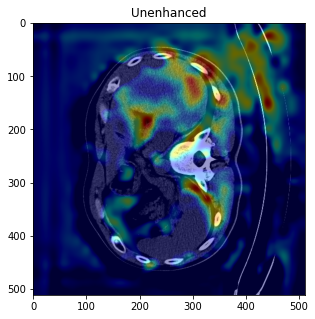

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


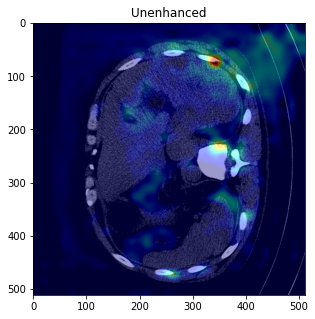

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


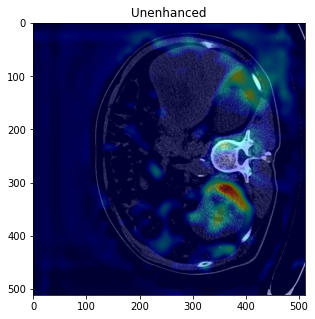

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


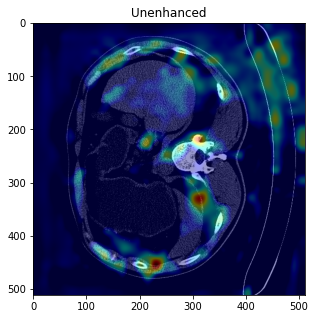

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


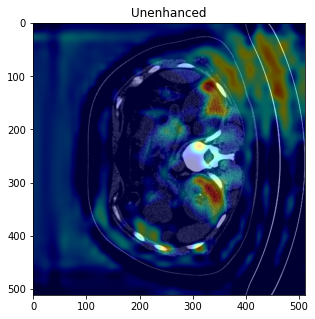

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


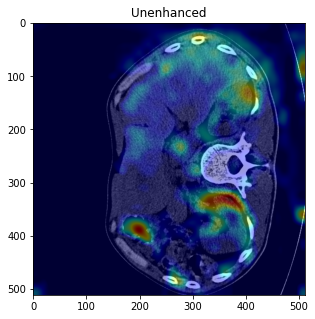

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


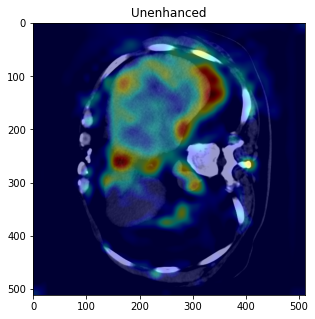

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


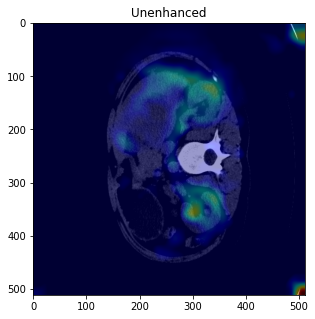

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


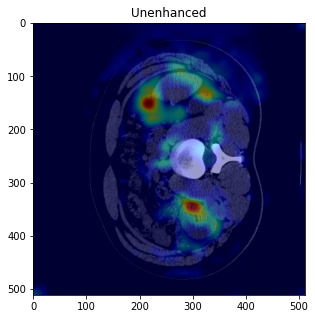

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


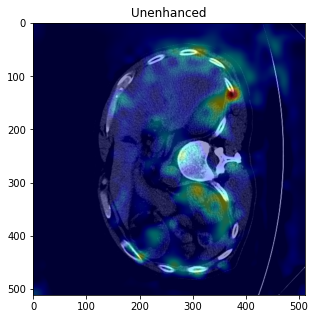

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


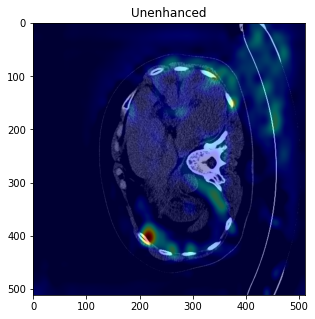

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


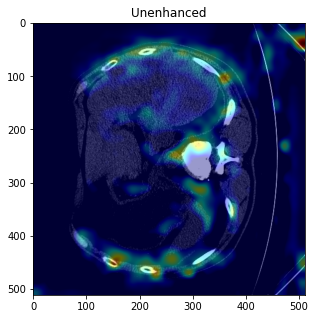

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


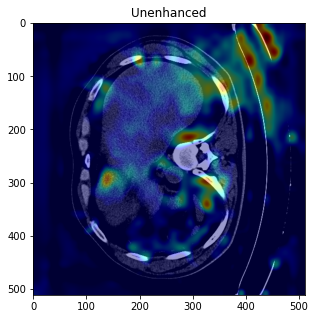

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


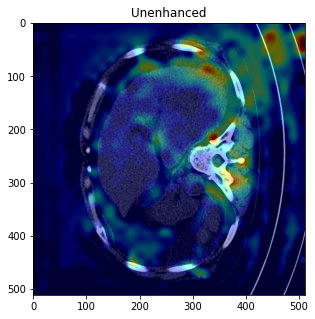

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


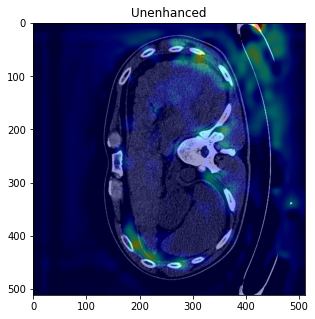

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


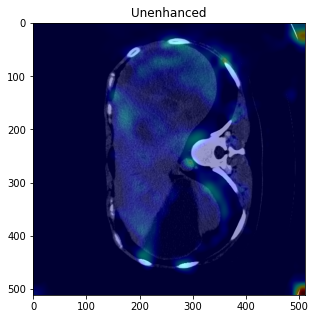

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


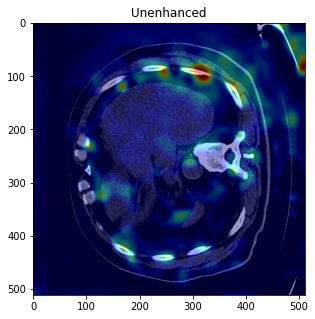

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


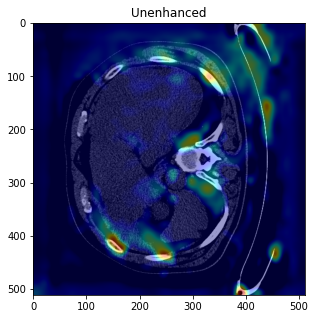

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


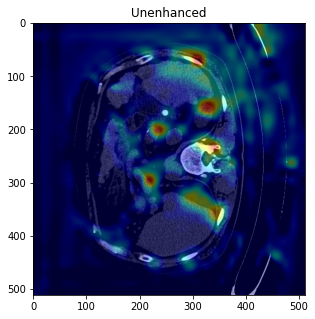

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


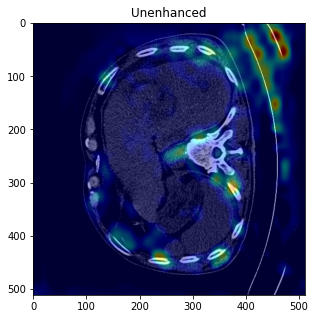

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


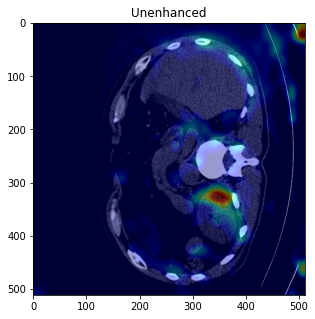

: 

In [13]:
for i in [1,20,40,50 ,102, 150,71, 202,250,300,420,510,560,450,800,1200,1270,333,275,999,840,723,1102]:

    input, label=train_dataset[i]
    out = CAM(torch.unsqueeze(input, 0), 1)
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = model(torch.unsqueeze(input, 0).cuda())
    _, predicted = torch.max(output.data, 1)

    #print(output.shape)
    #pred = (F.sigmoid(output)[:, 1, :, :] > 0.5).type(torch.uint8)
    print("True_label: {}, Pred_label: {}".format(label, predicted))
    plt.figure(figsize=(5,5))
    #plt.subplot(1,4,1)
    plt.title('Unenhanced')
    plt.imshow(input[1, :, :], cmap='gray')
    plt.imshow(heatmap, alpha=0.4)
    plt.show()
    # plt.subplot(1,4,2)
    # plt.title('Arterial')
    # plt.imshow(input[0, :, :], cmap='gray')
    # plt.imshow(heatmap, alpha=0.4)
    # plt.subplot(1,4,3)
    # plt.title('Portal')
    # plt.imshow(input[3, :, :], cmap='gray')
    # plt.imshow(heatmap, alpha=0.4)
    # plt.subplot(1,4,4)
    # plt.title('Delay')
    # plt.imshow(input[2, :, :], cmap='gray')
    # plt.imshow(heatmap, alpha=0.4)
    # plt.show()
    

    # plt.title('Real Mask')
    # plt.imshow(mask, cmap='gray')
    # plt.subplot(2, 3, 6)
    # plt.title('Pred Mask')
    # plt.imshow(pred.cpu()[0], cmap='gray')